[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Current Stock Price: 227.7899932861328
Historical Volatility: 0.2181519333017223
Black-Scholes call price: 20.490503143218575
Monte Carlo call price: 20.494920958796083
Binomial Tree call price: 20.490391769698544


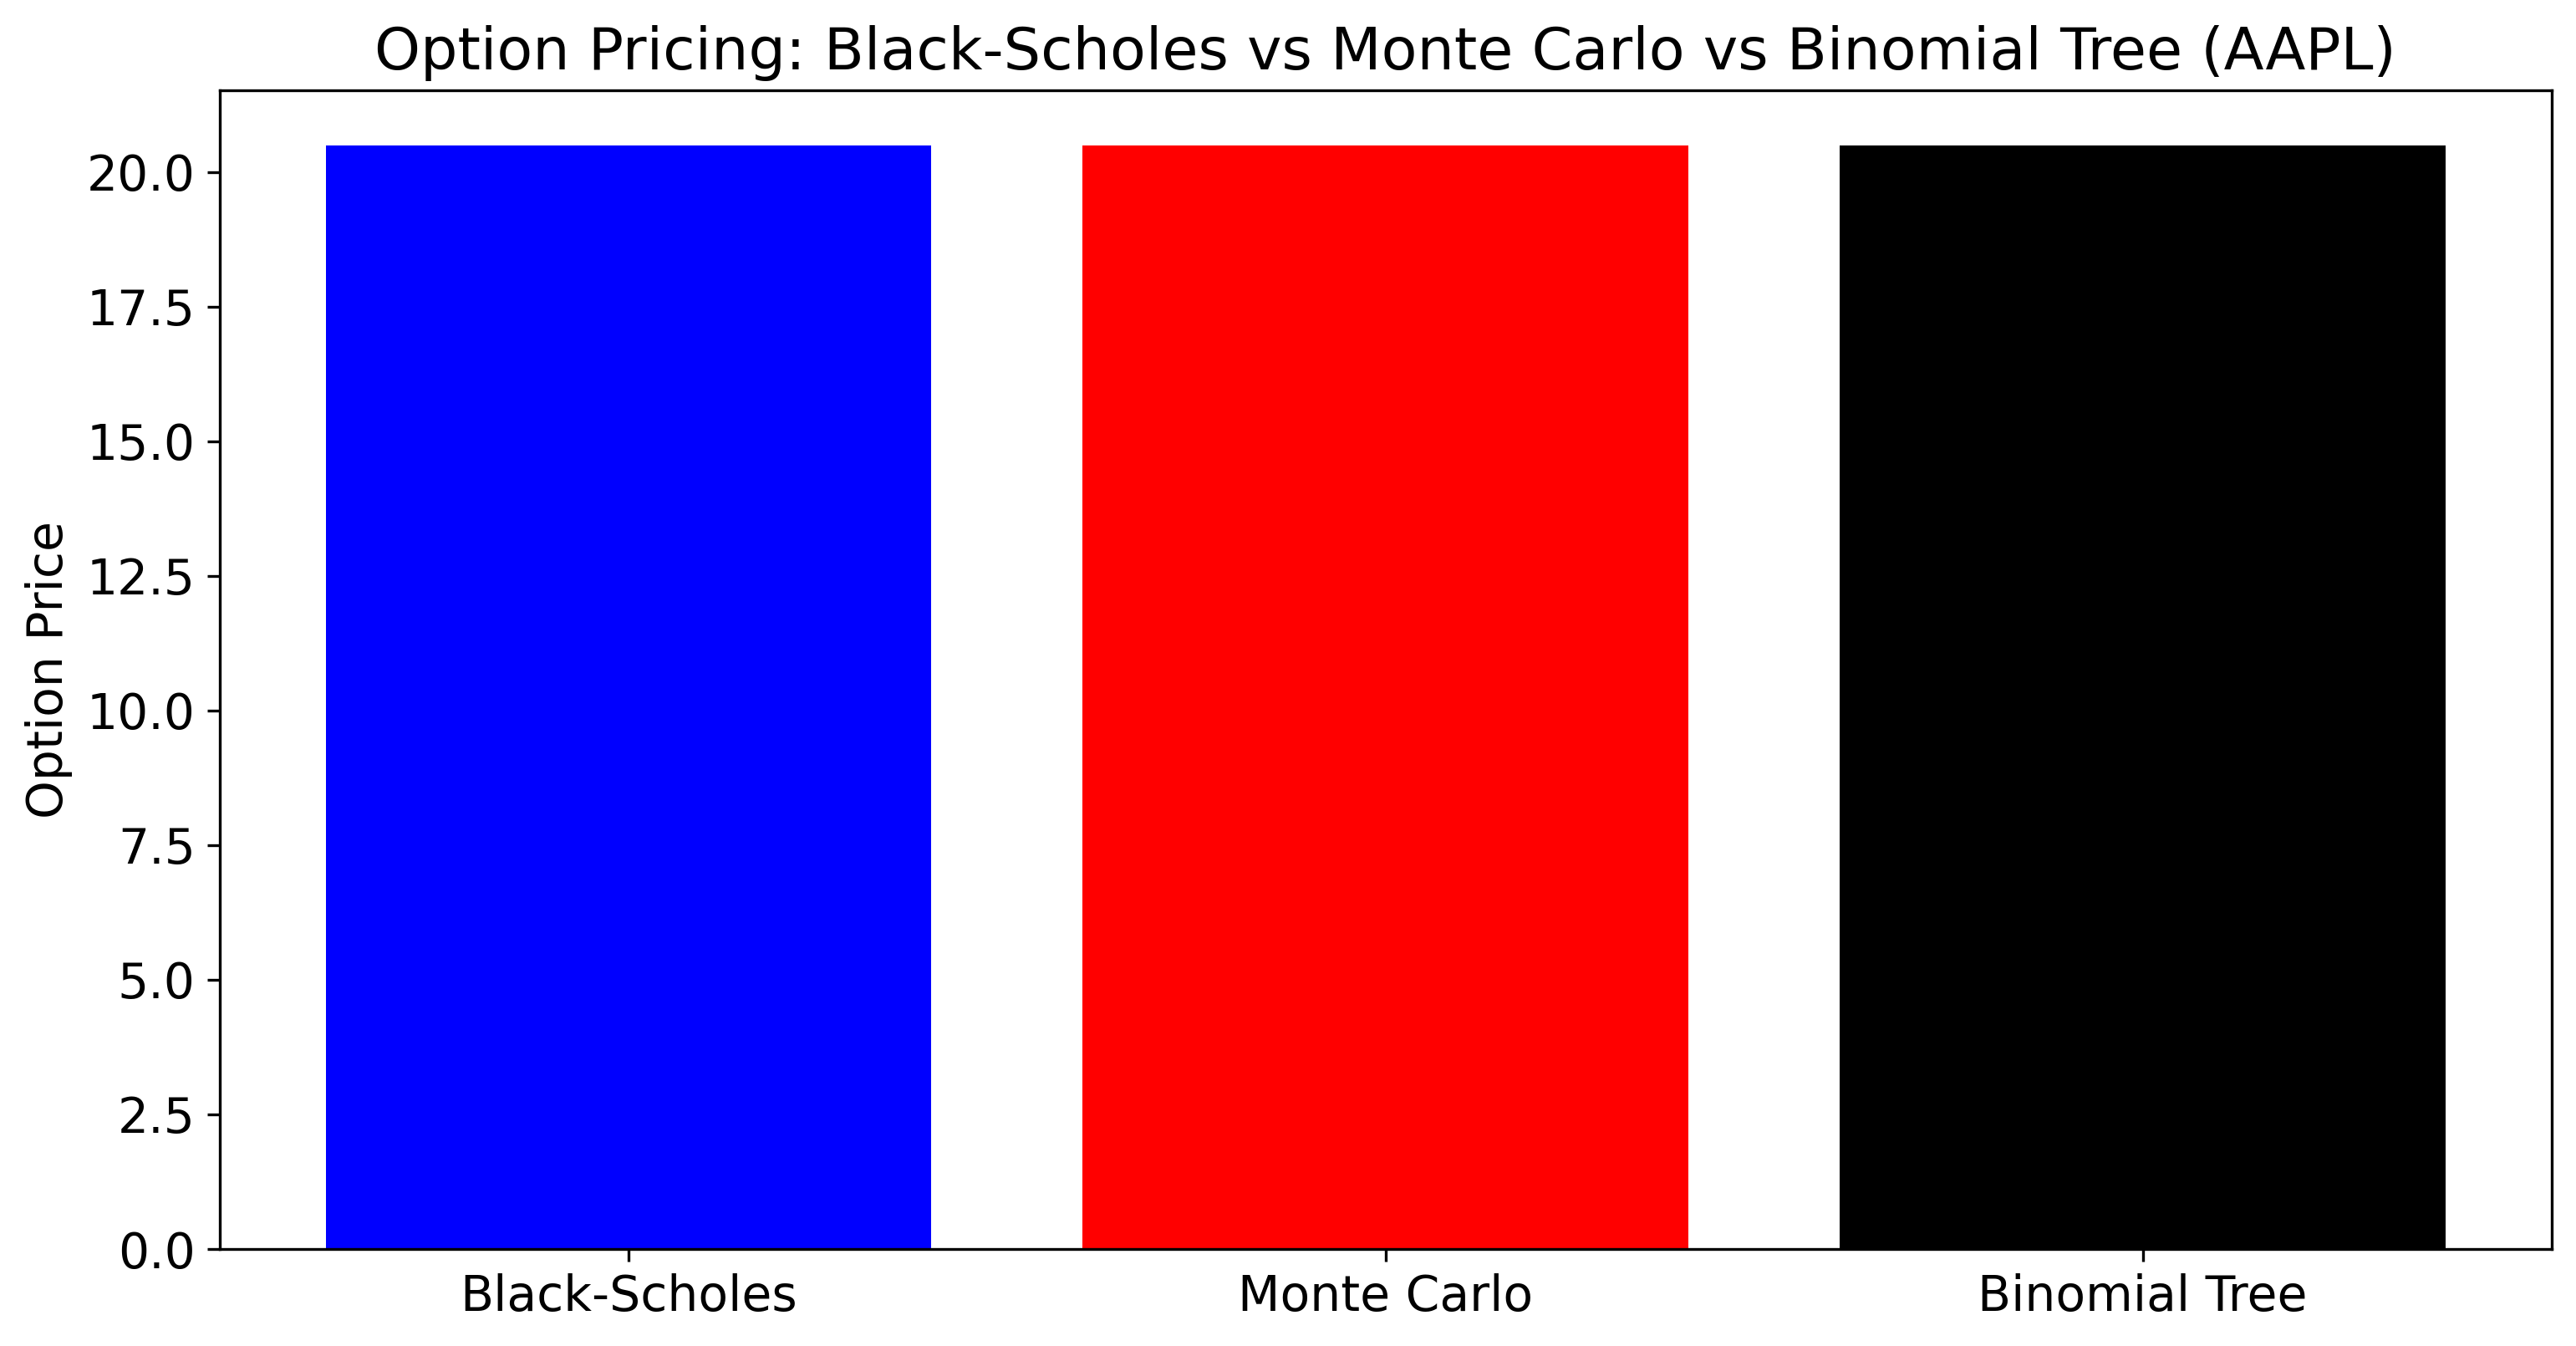

Greeks: Delta=0.999140467486701, Gamma=0.00042575873904476797, Vega=0.09242662529692824, Theta=-10.88086430144073, Rho=3.9718517278420946
Report saved to options_report.txt


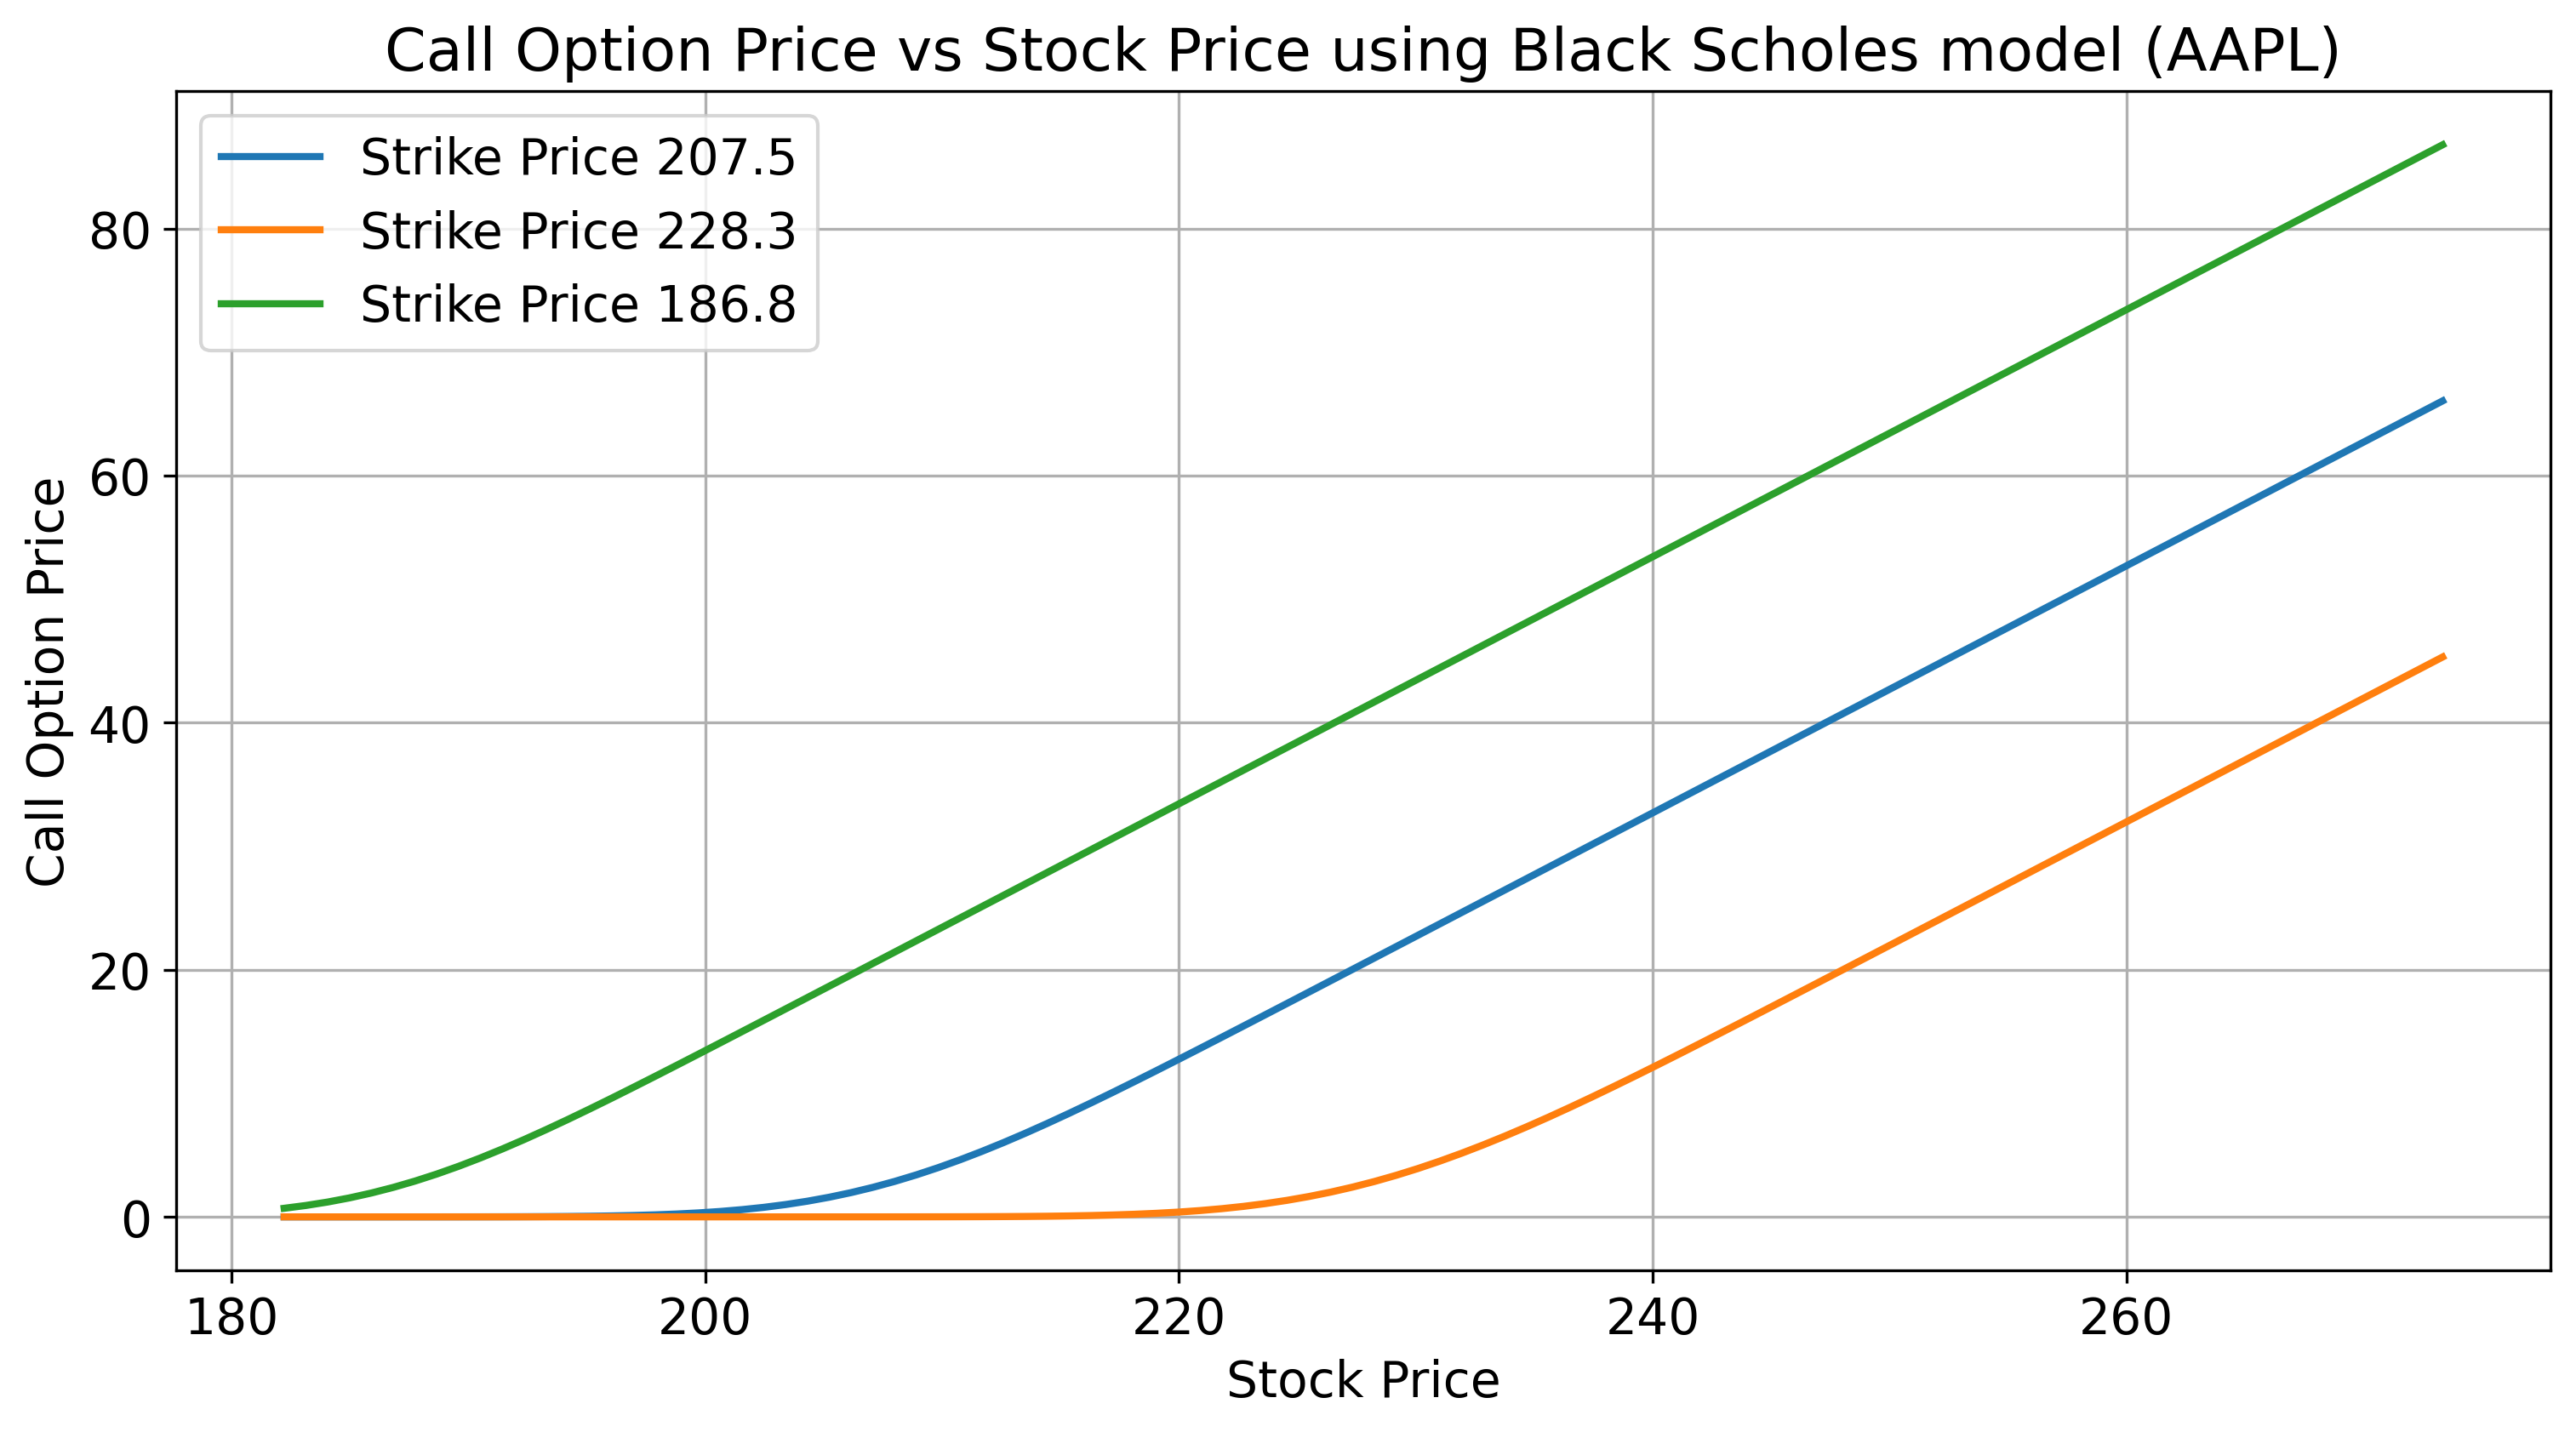

In [85]:
import os
from datetime import datetime

import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mticker




class OptionPricing:
    def __init__(self, ticker, option_type, output_folder='output'):
        """
        Initialises the option pricing class.

        Args:
            ticker (str): Stock ticker symbol.
            option_type (str): Option type ('call' or 'put'). Default is 'put'.
            output_folder (str): Directory to save output files. Default is 'output'.
        """
        self.ticker = ticker
        self.option_type = option_type
        self.output_folder = output_folder
        self.stock_data = None
        self.S = None  # Stock price
        self.sigma = None  # Volatility

    def black_scholes_option(self, S, K, T, r, sigma, option_type, q=0):
        """
        Calculate the option price using the Black-Scholes formula.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            q (float): Dividend rate. Default is 0.
            option_type: Call or put.

        Returns:
            float: Option price.
        """
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type == 'call':
            price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        return price

    def binomial_tree_option_price(self, S, K, T, r, sigma, N, option_type):
        """
        Calculate option price using the Binomial Tree method.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            N (int): Number of time steps.
            option_type: Call or put.
        Returns:
            float: Option price.
        """
        dt = T / N  # Time step
        u = np.exp(sigma * np.sqrt(dt))  # Up factor
        d = 1 / u  # Down factor
        p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

        # Initialise asset prices at maturity
        ST = np.array([S * (u ** (N - i)) * (d ** i) for i in range(N + 1)])

        # Initialise option values at maturity
        option_values = np.maximum(0, ST - K) if option_type == 'call' else np.maximum(0, K - ST)

        # Backward induction
        for j in range(N - 1, -1, -1):
            option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

        return option_values[0]

    def monte_carlo_option_price(self, S, K, T, r, sigma, num_simulations,option_type):
        """
        Calculate option price using Monte Carlo simulation.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            num_simulations (int): Number of simulations. Default is 10,000.
            option_type: Call or put.
        Returns:
            float: Option price and list of plot filenames.
        """
        dt = 1 / 365  # Daily steps
        num_steps = int(T * 365)  # Number of days until maturity
        payoffs = []
        paths = []
        estimated_prices = []

        for _ in range(num_simulations):
            ST = S
            path = [S]
            for _ in range(num_steps):
                Z = np.random.normal()
                ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
                path.append(ST)

            paths.append(path)
            payoff = max(0, ST - K) if option_type == 'call' else max(0, K - ST)
            payoffs.append(payoff)
            estimated_prices.append(np.exp(-r * T) * np.mean(payoffs))

        plot_filenames = self.plot_simulation(paths, payoffs, estimated_prices)

        return np.exp(-r * T) * np.mean(payoffs), plot_filenames


    def plot_simulation(self, paths, payoffs, estimated_prices):
        """
        Plots simulation results: paths, payoffs, and convergence.

        Args:
            paths (list): Stock price paths.
            payoffs (list): Payoffs of the options.
            estimated_prices (list): Convergence of the estimated prices.
        """
        os.makedirs(self.output_folder, exist_ok=True)
        # Set common styling for plots
        plt.rcParams.update({
            'font.size': 14,           # Font size
            'lines.linewidth': 2,      # Line width
            'figure.dpi': 300          # Image quality
        })
        # Plot stock price paths
        path_filename = os.path.join(self.output_folder, 'Monte_Carlo_Paths.png')
        plt.figure(figsize=(12, 6))
        for path in paths[:200]:  # Limit to 200 paths for clarity
            plt.plot(path, linewidth=0.5)
        plt.title(f'Monte Carlo Simulation of Stock Price Paths ({self.ticker})')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.savefig(path_filename)
        plt.close()  # Close the plot to avoid displaying it inline

        # Histogram of payoffs
        payoff_filename = os.path.join(self.output_folder, 'Payoff_Histogram.png')
        plt.figure(figsize=(12, 6))
        plt.hist(payoffs, bins=50)
        plt.title(f'Histogram of Simulated Payoffs ({self.ticker})')
        plt.xlabel('Payoff')
        plt.ylabel('Frequency')
        plt.savefig(payoff_filename)
        plt.close()

        # Convergence plot
        convergence_filename = os.path.join(self.output_folder, 'Convergence_Plot.png')
        plt.figure(figsize=(12, 6))
        plt.plot(estimated_prices, color='blue')
        plt.title(f'Convergence of Monte Carlo Option Price ({self.ticker})')
        plt.xlabel('Number of Simulations')
        plt.ylabel('Option Price Estimate')
        plt.savefig(convergence_filename)
        plt.close()

        return [path_filename, payoff_filename, convergence_filename]


    def greeks(self, S, K, T, r, sigma, q=0):
        """
        Calculate the Greeks for the option.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            q (float): Dividend rate. Default is 0.

        Returns:
            tuple: Delta, Gamma, Vega, Theta, and Rho.
        """
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if self.option_type == "call":
            delta = norm.cdf(d1)
            theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) -
                     r * K * np.exp(-r * T) * norm.cdf(d2))
            rho = K * T * np.exp(-r * T) * norm.cdf(d2)
        else:
            delta = norm.cdf(d1) - 1
            theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) +
                     r * K * np.exp(-r * T) * norm.cdf(-d2))
            rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

        return delta, gamma, vega, theta, rho
    

    def implied_volatility(self, S, K, T, r, market_price):
        """
        Calculate implied volatility using the market price.
        This method tries Newton-Raphson first, then Bisection, and finally Brent's method.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.

        Returns:
            float: Implied volatility.
        """
        
        # Try Newton-Raphson method first
        try:
            sigma = self.implied_volatility_newton(S, K, T, r, market_price)
            return sigma
        except ValueError as e:
            print(f"Newton-Raphson method failed: {e}")
            print("Falling back to Bisection method.")

        # Fallback to Bisection method
        try:
            sigma = self.implied_volatility_bisection(S, K, T, r, market_price)
            return sigma
        except ValueError as e:
            print(f"Bisection method failed: {e}")
            print("Falling back to Brent's method.")

        # Final fallback to Brent's method
        return self.implied_volatility_brent(S, K, T, r, market_price)

    def implied_volatility_newton(self, S, K, T, r, market_price, max_iterations=10000, tolerance=1e-6, relaxation_factor=0.15):
        """
        Calculate implied volatility using the market price, with optional relaxation factor for Newton-Raphson.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.
            relaxation_factor (float): A factor (0 < relaxation_factor <= 1) to control step size.

        Returns:
            float: Implied volatility.
        """
        # Use historical volatility as the initial guess
        sigma = self.sigma if self.sigma is not None else 0.2  # Fallback if historical volatility is not calculated

        for _ in range(max_iterations):
            # Calculate the option price with the current sigma
            price = self.black_scholes_option(S, K, T, r, sigma, self.option_type)
            
            # Calculate the vega (the sensitivity of the option price to volatility)
            vega = self.greeks(S, K, T, r, sigma)[2]

            # Calculate the price difference
            price_diff = price - market_price

            # If the price difference is within the tolerance, return the sigma
            if abs(price_diff) < tolerance:
                return sigma

            # Ensure vega is not zero to avoid division by zero
            if vega == 0:
                raise ValueError("Vega is zero, cannot update volatility.")

            # Apply the relaxation factor to control the step size of the update
            delta_sigma = relaxation_factor * (price_diff / vega)
            sigma -= delta_sigma

            # Optional: Limit the value of sigma to avoid extreme values
            sigma = max(0.01, min(5.0, sigma))  # Cap the volatility between 0.01 and 5.0

        # raise ValueError("Implied volatility could not be found within the specified iterations.")

    
    
    def implied_volatility_bisection(self, S, K, T, r, market_price, lower_bound=0.01, upper_bound=5.0, max_iterations=100, tolerance=1e-6):
        def price_difference(sigma):
            return self.black_scholes_option(S, K, T, r, sigma, self.option_type) - market_price

        f_lower = price_difference(lower_bound)
        f_upper = price_difference(upper_bound)
        if f_lower * f_upper > 0:
            raise ValueError("The function must have different signs at the lower and upper bounds.")

        for _ in range(max_iterations):
            mid = (lower_bound + upper_bound) / 2
            f_mid = price_difference(mid)

            if abs(f_mid) < tolerance:
                return mid

            if f_lower * f_mid < 0:
                upper_bound = mid
                f_upper = f_mid
            else:
                lower_bound = mid
                f_lower = f_mid

        # raise ValueError("Implied volatility could not be found within the specified iterations.")

    def implied_volatility_brent(self, S, K, T, r, market_price):
        """
        Calculate implied volatility using Brent's method (brentq).

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.

        Returns:
            float: Implied volatility.
        """
        def option_price_diff(sigma):
                price = self.black_scholes_option(S, K, T, r, sigma, self.option_type, q=0)
                price_diff = price - market_price
                print(f"Sigma: {sigma:.4f}, Calculated Price: {price:.4f}, Market Price: {market_price:.4f}, Price Diff: {price_diff:.4f}")
                return price_diff

        try:
            # Define boundaries
            low = 1e-6
            high = 10
            low_value = option_price_diff(low)
            high_value = option_price_diff(high)
            
            # Check if the signs are opposite at boundaries
            if low_value * high_value > 0:
                print("Volatility couldn't be found: Function does not have opposite signs at the boundaries.")
                return None
            
            # Try using brentq to solve for implied volatility
            implied_vol = brentq(option_price_diff, low, high)
            return implied_vol

        except ValueError as e:
            # Catch the error if brentq fails
            print(f"Volatility couldn't be found with any of the 3 methods. The imported market value should be checked: {e}")
            return None


    def get_stock_data(self):
        """
        Fetch stock data from Yahoo Finance.
        """
                
        # """
        # Fetch the latest stock data from Yahoo Finance.
        # """
        try:
            # Fetch data for a short period to get the latest price
            self.data = yf.download(self.ticker, period="1d")
            if self.data.empty:
                raise ValueError("No data found for the given ticker.")
            
            if 'Adj Close' in self.data.columns and not self.data['Adj Close'].empty:
                self.S = self.data['Adj Close'].iloc[-1]
                print('Current Stock Price:', self.S)
            else:
                raise ValueError("Adjusted Close data is not available.")

        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None


    def calculate_historical_volatility(self, start_date, end_date, window=252):
        """
        Calculate the historical volatility based on stock price data.

        Args:
            start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
            end_date (str): End date for the historical data in "YYYY-MM-DD" format.
            window (int): Rolling window for volatility calculation (default is 252 days).

        Returns:
            float: Annualised historical volatility.
        """
        try:
            self.data = yf.download(self.ticker, start=start_date, end=end_date)
            if self.data.empty:
                raise ValueError("No data found for the given ticker.")
            
            if 'Adj Close' in self.data.columns and not self.data['Adj Close'].empty:
                self.data['Returns'] = self.data['Adj Close'].pct_change()
                historical_volatility = self.data['Returns'].std() * np.sqrt(252)  # Annualised volatility
                self.sigma = historical_volatility  # Store volatility for use in other methods
                return historical_volatility
            else:
                raise ValueError("Adjusted Close data is not available.")
            
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None

            
    
    def generate_report(self, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price):
        os.makedirs(self.output_folder, exist_ok=True)

        report = f"""
        Options Pricing and Greeks Calculation Report

        1. User Inputs:
        - Option type: {option_type}
        - Stock Ticker: {self.ticker}
        - Stock Price (S): {S:.1f}
        - Strike Price (K): {K}
        - Days to Expiration: {int(T * 365)} days
        - Risk-Free Rate (r): {r * 100:.2f}%
        - Market Price of the Option: {market_price}
        - Start and end date for calculating Historical Volatility: {start_date_volatility} - {end_date_volatility}

        2. Calculated Intermediate Values:
        - Time to Maturity (T): {T:.4f} years
        - Historical Volatility (σ): {sigma * 100:.2f}%

        3. Option Prices:
        - Option Price (Black-Scholes): {bs_price:.2f} 
        - Option Price (Monte Carlo): {mc_price[0]:.2f}
        - Option Price (Binomial Tree): {bt_price:.2f} 

        4. Greeks:
        - Delta: {delta:.4f}
        - Gamma: {gamma_val:.4f}
        - Vega: {vega_val:.4f}
        - Theta: {theta_val:.4f}
        - Rho: {rho_val:.4f}

        5. Implied Volatility Calculation:
        - Implied Volatility (IV): {'Not found (check the imported market price)' if iv is None else f'{iv * 100:.2f}%'}
        """
        
        report_path = os.path.join(self.output_folder, "options_report.txt")
        with open(report_path, "w") as file:
            file.write(report)

        print("Report saved to options_report.txt")

    def plot_option_price_vs_stock_price(self, S_range, K_list, T, r, sigma):
        # Set common styling for plots
        plt.rcParams.update({
            'font.size': 14,           # Font size
            'lines.linewidth': 2,      # Line width
            'figure.dpi': 300          # Image quality
        })
        plt.figure(figsize=(12, 6))
        for K in K_list:
            option_prices = [self.black_scholes_option(S, K, T, r, sigma, self.option_type, q=0) for S in S_range]
            plt.plot(S_range, option_prices, label=f"Strike Price {K:.1f}")

        plt.title(f"{self.option_type.capitalize()} Option Price vs Stock Price using Black Scholes model ({self.ticker})")
        plt.xlabel("Stock Price")
        plt.ylabel(f"{self.option_type.capitalize()} Option Price")
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.output_folder, 'Option_price_vs_stock_price.png')
        plt.savefig(plot_path)
        plt.show()
    # Function for Comparative Pricing Visualisation
    def comparative_pricing_plot(self, bs_price, mc_price, bt_price):
        methods = ['Black-Scholes', 'Monte Carlo', 'Binomial Tree']
        prices = [bs_price, mc_price[0], bt_price]
        # Set common styling for plots
        plt.rcParams.update({
            'font.size': 14,           # Font size
            'lines.linewidth': 2,      # Line width
            'figure.dpi': 300          # Image quality
        })
        plt.figure(figsize=(12, 6))
        plt.bar(methods, prices, color=['blue', 'red', 'black'])
        plt.title(f'Option Pricing: Black-Scholes vs Monte Carlo vs Binomial Tree ({self.ticker})')
        plt.ylabel('Option Price')
        plot_comparison = os.path.join(self.output_folder, 'Pricing_Comparison.png')
        plt.savefig(plot_comparison)
        plt.show()


    def backtest(self, file_path, n_data = None, n_each_day = 5, risk_free_rate=0.05, num_steps=100, keep_first_n_rows_per_date='False'):
        # Load the data
        # Load the data
        if n_data is not None:
            self.stock_data = pd.read_csv(file_path, nrows=n_data)
        else:
            self.stock_data = pd.read_csv(file_path)        
        # Filter for the desired ticker
        self.stock_data = self.stock_data[self.stock_data['act_symbol'] == self.ticker]
        
        # Optionally keep only one row per date
        if keep_first_n_rows_per_date:
            self.stock_data = self.stock_data.groupby('date').head(n_each_day)  # Keep the first 5 records for each date


        # Calculate mid prices
        self.stock_data['mid_price'] = (self.stock_data['bid'] + self.stock_data['ask']) / 2
        
        # Initialize columns for theoretical prices
        self.stock_data['BS_price'] = np.nan
        self.stock_data['BT_price'] = np.nan
        self.stock_data['MC_price'] = np.nan
        
        for index, row in self.stock_data.iterrows():
            S = row['stock_price']
            K = row['strike']
            T = (pd.to_datetime(row['expiration']) - pd.to_datetime(row['date'])).days / 365  # Time to maturity
            sigma = row['implied_volatility']
            option_type = row['call_put'].lower()

            # Calculate theoretical prices
            bs_price = self.black_scholes_option(S, K, T, risk_free_rate, sigma, option_type)
            bt_price = self.binomial_tree_option_price(S, K, T, risk_free_rate, sigma, num_steps, option_type)
            mc_price = self.monte_carlo_option_price(S, K, T, risk_free_rate, sigma, 10000, option_type)
            
            # Store the calculated prices
            self.stock_data.at[index, 'BS_price'] = bs_price
            self.stock_data.at[index, 'BT_price'] = bt_price
            self.stock_data.at[index, 'MC_price'] = mc_price[0]

        # Calculate errors
        self.stock_data['BS_error'] = self.stock_data['BS_price'] - self.stock_data['mid_price']
        self.stock_data['BT_error'] = self.stock_data['BT_price'] - self.stock_data['mid_price']
        self.stock_data['MC_error'] = self.stock_data['MC_price'] - self.stock_data['mid_price']

        # Calculate percentage errors
        self.stock_data['BS_error_pct'] = ((self.stock_data['BS_price'] - self.stock_data['mid_price']) / self.stock_data['mid_price']) * 100
        self.stock_data['BT_error_pct'] = ((self.stock_data['BT_price'] - self.stock_data['mid_price']) / self.stock_data['mid_price']) * 100
        self.stock_data['MC_error_pct'] = ((self.stock_data['MC_price'] - self.stock_data['mid_price']) / self.stock_data['mid_price']) * 100

        # Compute error metrics
        mae_bs = self.stock_data['BS_error'].abs().mean()
        rmse_bs = (self.stock_data['BS_error'] ** 2).mean() ** 0.5
        
        mae_bt = self.stock_data['BT_error'].abs().mean()
        rmse_bt = (self.stock_data['BT_error'] ** 2).mean() ** 0.5
        
        mae_mc = self.stock_data['MC_error'].abs().mean()
        rmse_mc = (self.stock_data['MC_error'] ** 2).mean() ** 0.5

        print(f'Black-Scholes MAE: {mae_bs}, RMSE: {rmse_bs}')
        print(f'Binomial Tree MAE: {mae_bt}, RMSE: {rmse_bt}')
        print(f'Monte Carlo MAE: {mae_mc}, RMSE: {rmse_mc}')

        # Create output directories
        backtest_folder = os.path.join(self.output_folder, 'backtesting')
        os.makedirs(backtest_folder, exist_ok=True)

        # Save results to output folder
        self.stock_data.to_csv(f'output/backtesting/{self.ticker}_backtest_results.csv', index=False)
        backtest_results = self.stock_data

        # Convert 'expiration' to datetime format
        backtest_results['expiration'] = pd.to_datetime(backtest_results['expiration'])

        # Sort the DataFrame based on the 'expiration' column
        backtest_results = backtest_results.sort_values(by='expiration')

        # Set common styling for plots
        plt.rcParams.update({
            'font.size': 14,           # Font size
            'lines.linewidth': 5,      # Line width
            'figure.dpi': 300          # Image quality
        })

        # 1. Scatter Plot of Mid Price vs. Model Prices
        backtest_results = backtest_results.sort_values(by='mid_price')

        plt.figure(figsize=(12, 6))
        plt.plot(backtest_results['mid_price'], backtest_results['BS_price'], 
                label='Black-Scholes Price', marker='o', color='blue', linestyle='-')
        plt.plot(backtest_results['mid_price'], backtest_results['BT_price'], 
                label='Binomial Tree Price', marker='o', color='black', linestyle='--')
        plt.plot(backtest_results['mid_price'], backtest_results['MC_price'], 
                label='Monte Carlo Price', marker='o', color='red', linestyle=':')

        plt.xlabel('Mid Option Price')
        plt.ylabel('Predicted Option Price')
        plt.title(f'Option Mid Price vs. Model Prices for {self.ticker} (2013)')
        plt.legend()
        plt.tight_layout()
        plt.savefig('output/backtesting/mid_price_vs_model_prices.png')
        plt.show()  # Display the plot
        plt.close()

        # Sort the DataFrame based on the 'strike' column
        backtest_results_sorted = backtest_results.sort_values(by='strike')
        # 2. Line Plot of Price Across Dates

        backtest_results_sorted_zero_removed = backtest_results_sorted[backtest_results_sorted['mid_price']>5]
        backtest_results_sorted_zero_removed = backtest_results_sorted_zero_removed.sort_values(by='date')
        plt.figure(figsize=(12, 6))

        # Plot Black-Scholes Prediction
        plt.plot(backtest_results_sorted_zero_removed['date'], 
                backtest_results_sorted_zero_removed['MC_price'], 
                label='Monte Carlo Prediction', marker='o', color='red', linestyle='-')

        # Plot Mid Price
        plt.plot(backtest_results_sorted_zero_removed['date'], 
                backtest_results_sorted_zero_removed['mid_price'], 
                label='Mid Price', marker='o', color='black', linestyle='--')

        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title(f'Price Across Dates for {self.ticker} (2013)')
        # Customize x-ticks: Show only every nth date to avoid overcrowding
        n_ticks = 10  # Adjust this to control the number of dates shown
        dates = backtest_results_sorted_zero_removed['date']
        plt.xticks(dates[::n_ticks], rotation=45)  # Show every nth date, rotated for readability
        plt.legend()
        plt.tight_layout()
        plt.savefig('output/backtesting/price_vs_date_plot.png')
        plt.show()
        plt.close()
        # display(backtest_results)
        return backtest_results

    
if __name__ == "__main__":
   # Initialize the OptionPricing class
    OUTPUT_FOLDER = "output"

    # For historical volatility
    start_date_volatility = datetime(2023, 1, 1).strftime('%Y-%m-%d')
    end_date_volatility = datetime.today().strftime('%Y-%m-%d')

    # For Monte Carlo
    mc_num_sim = 10000
    bt_num_step = 100

   # AAPL
    ticker = "AAPL"  # Example ticker
    option_type = "call"  # Can be 'call' or 'put'
    K = 207.5  # Example strike price
    days_to_maturity = 7
    T = days_to_maturity / 365  # Time to maturity (in years)
    r = 0.05  # Example risk-free rate
    market_price = 22.25  # Example market price

    # TSLA

    # ticker = "TSLA"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 225  # Example strike price
    # days_to_maturity = 25
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 30.8  # Example market price

    # NVDA
    # ticker = "NVDA"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 104  # Example strike price
    # days_to_maturity = 11
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 12  # Example market price

    # ABNB
    # ticker = "ABNB"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 118  # Example strike price
    # days_to_maturity = 4
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 11.8  # Example market price

    # ticker = "BNTX"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 105  # Example strike price
    # days_to_maturity = 25
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 9.6  # Example market price
    

   # AAPL
    # ticker = "AAPL"  # Example ticker
    # option_type = "put"  # Can be 'call' or 'put'
    # K = 400  # Example strike price
    # days_to_maturity = 2
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 0.01  # Example market price

    option = OptionPricing(ticker, option_type)

    # Fetch stock data and calculate historical volatility
    option.get_stock_data()
    historical_vol = option.calculate_historical_volatility(start_date_volatility, end_date_volatility)
    print(f"Historical Volatility: {historical_vol}")


    sigma = historical_vol
    # Parameters for the option
    S = option.S

    # Calculate Black-Scholes price
    bs_price = option.black_scholes_option(S, K, T, r, sigma, option_type, q=0)
    print(f"Black-Scholes {option_type} price: {bs_price}")


    # Calculate Monte Carlo price
    mc_price = option.monte_carlo_option_price(S, K, T, r, sigma,mc_num_sim, option_type)
    print(f"Monte Carlo {option_type} price: {mc_price[0]}")
    
    # Calculate Binomial Tree price
    bt_price = option.binomial_tree_option_price(S, K, T, r, sigma, bt_num_step,option_type)
    print(f"Binomial Tree {option_type} price: {bt_price}")
    
    # Generate comparative pricing plot
    option.comparative_pricing_plot(bs_price, mc_price, bt_price)
    
    # Calculate Greeks
    delta, gamma, vega, theta, rho = option.greeks(S, K, T, r, sigma)
    print(f"Greeks: Delta={delta}, Gamma={gamma}, Vega={vega}, Theta={theta}, Rho={rho}")

    # Example implied volatility from a market price
    # implied_vol = option.implied_volatility(S, K, T, r, market_price)
    implied_vol = option.implied_volatility(S, K, T, r, market_price)


    # Generate report
    option.generate_report(S, K, T, r, sigma, bs_price, delta, gamma, vega, theta, rho, implied_vol, market_price, mc_price, bt_price)

    # Plot option prices vs stock price
    S_range = np.linspace(S * 0.8, S * 1.2, 100)
    K_list = [K, K * 1.1, K * 0.9]
    option.plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma)


/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_66130/3990406399.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_66130/3990406399.py:80: RuntimeWarning: invalid value encountered in scalar divide
  p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability


Black-Scholes MAE: 0.17161435317431886, RMSE: 0.22527593744431426
Binomial Tree MAE: 0.17452106238553827, RMSE: 0.23285667602605636
Monte Carlo MAE: 0.2144800429148351, RMSE: 0.2844171972797034


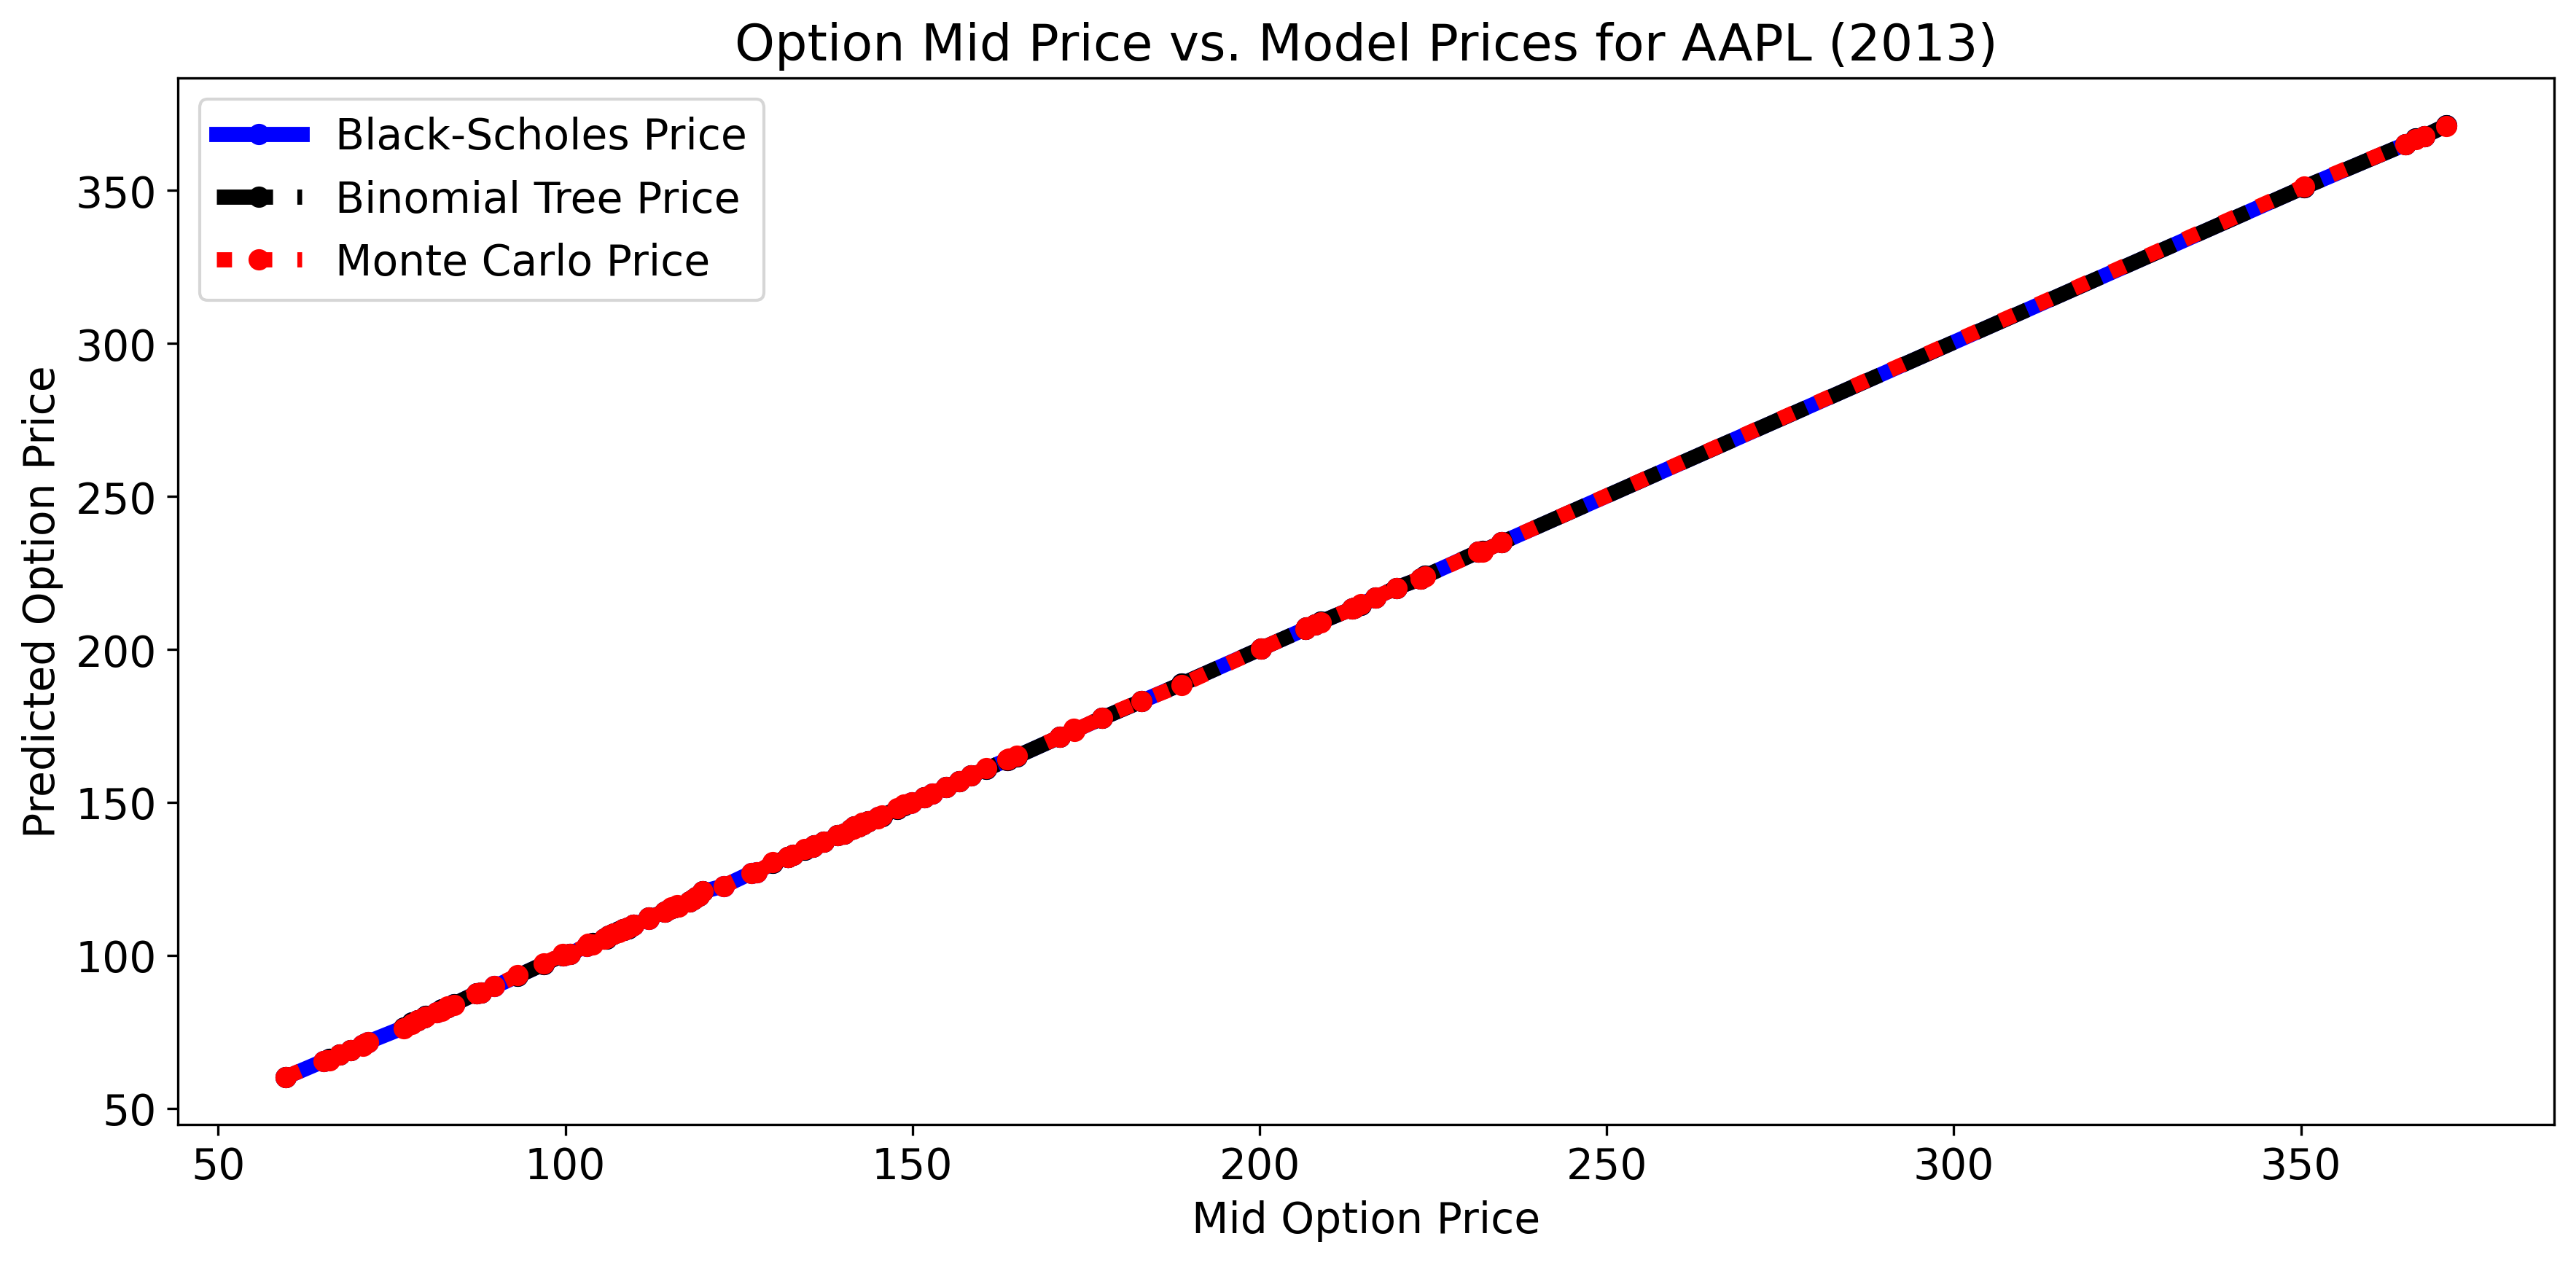

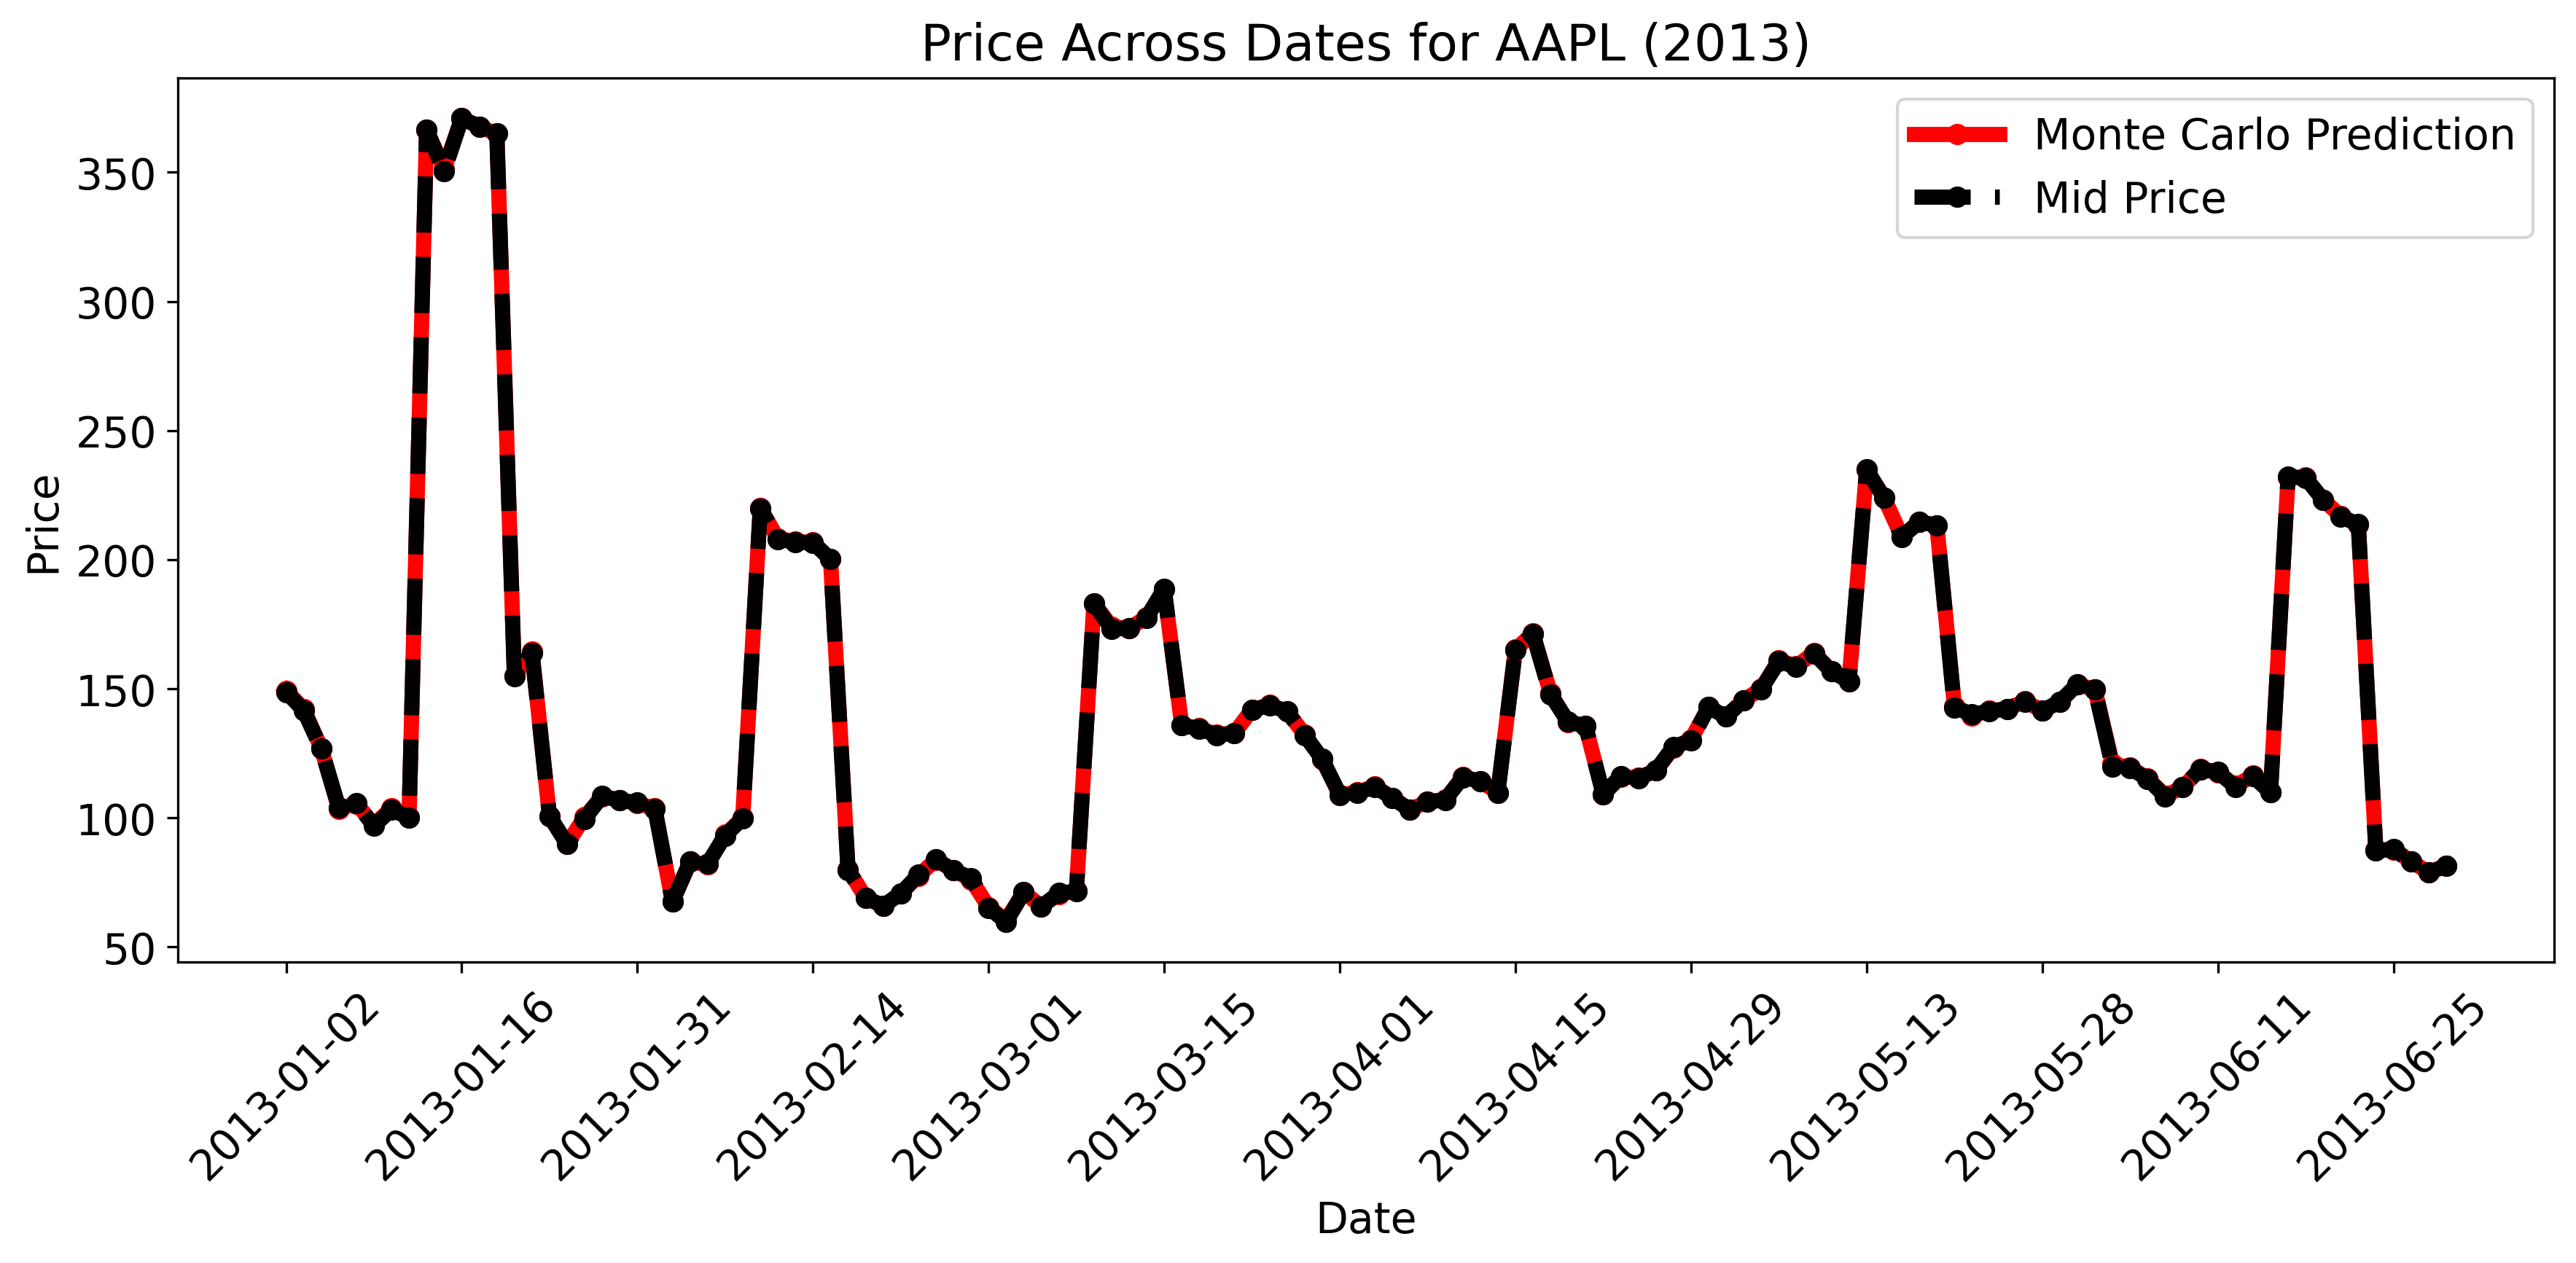

In [86]:
file_path = 'backtesting-data/Optiondataorg/AAPL_2013.csv'

backtest_results = option.backtest(file_path, n_each_day = 1, keep_first_n_rows_per_date=True)